# Vortices near airfoil

In [1]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
using Profile

clibrary(:colorbrewer)
default(grid = false)

In [2]:
mutable struct Vortex
    x::Real
    y::Real
    Γ::Real
end

### Eulerian grid

In [3]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
display(dx)
s = Nodes(Dual,(nx,ny));
stot = Nodes(Dual,(nx,ny));
q = Edges(Primal,(nx,ny));

L = plan_laplacian(size(s),with_inverse=true)
L⁻¹(s::T) where {T} = L\s;

0.015873015873015872

### Body

In [4]:
n = 100

c = 1.0
body = NACA4(0.0,0.0,0.12,np=n,len=c)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))
println("Ratio of arc spacing to cell size = ",ds/dx)

# Move the airfoil
xc = 1.0; yc = 1.0
α = 20π/180
T = RigidTransform((xc,yc),-α)
T(body)

Ratio of arc spacing to cell size = 0.09432401714789734


NACA 4-digit airfoil with 199 points and length 1.0 and thickness 0.12
   Current position: (1.0,1.0)
   Current angle (rad): -0.3490658503988659


In [5]:
X = VectorData(body.x,body.y)
f = ScalarData(X);
const oB = ones(length(X.u));

# The desired streamfunction on the airfoil surface
# free stream
U∞ = 1
const ψb = -U∞*(body.y .- body.cent[2]);

# The desired circulation about the airfoil
Γ0 = -π*c*U∞*sin(α);

### Schur complement of 2-by-2 saddle system

In [6]:
E = Regularize(X,dx;issymmetric=true);
Hmat,Emat = RegularizationMatrix(E,f,s);
PS = SaddleSystem((s,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
S = Matrix(PS.S);
const Sinv = inv(S);

### Vortices

In [7]:
vortex_1 = Vortex(0.5,1.0,1.0)

vortices = Array{Vortex,1}()
push!(vortices,vortex_1)

1-element Array{Vortex,1}:
 Vortex(0.5, 1.0, 1.0)

Test streamfunction

In [8]:
xg,yg = coordinates(s,dx=dx)

w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w)
f = ScalarData(X);
S₀ = transpose(oB)*(S\oB)

T = S - oB*transpose(oB)/S₀;
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))
ψ .= -(L\(Hmat*f)) .+ ψ₀;
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ U∞*(yg' .- body.cent[2]); # adding the free-stream streamfunction

System plot

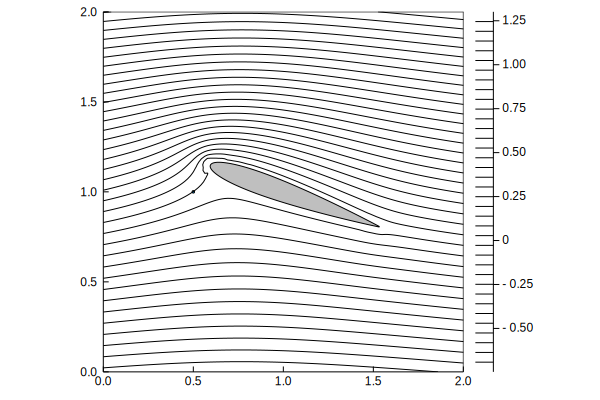

In [9]:
scatter((v->v.x).(vortices),(v->v.y).(vortices),ratio=:equal,markersize=1)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
plot!(xg,yg,ψtot,linecolor=:black,levels=36)
plot!(xlims=(0,Lx),ylims=(0,Lx))

In [10]:
function rhs(vortices_loc::VectorData,params::Tuple{Nodes,Edges,ScalarData,ScalarData,Array{Float64}},t::Float64)

    s = params[1]
    q = params[2]
    vortices_Γ = params[3]
    f = params[4]
    Sinv = params[5]
        
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(s,vortices_Γ)
    
    # Solve potential flow 
    s .= L\s
    S₀ = transpose(oB)*(Sinv*oB);
    f .= Sinv*((S .- oB*transpose(oB)./S₀)*(Sinv*(Emat*s .+ ψb)) .+ Γ0.*oB./S₀);
    ψ₀ = -1/S₀*(Γ0 - transpose(oB)*Sinv*(Emat*s .+ ψb));
    s .= -(L\(Hmat*f)) .- s .+ ψ₀; 
    stot .= 0;
    stot .= s .+ U∞*(yg' .- body.cent[2]); # adding the free-stream streamfunction
    
    # Calculate velocity field
    q .= curl(stot)/(dx);
    
    
    vel = VectorData(vortices_Γ)
    
    # Interpolate to nodes before interpolating to vortex point
    Fields.interpolate!((s),q.u);
    Hw(vel.u,s)
    Fields.interpolate!((s),q.v);
    Hw(vel.v,s)
    
    return vel
    
end 

rhs (generic function with 1 method)

### Time marching

In [84]:
tf = 1.0
tspan = (0.0,tf);#0.25
vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
# u0 = [vortices_loc.u vortices_loc.v]
prob = ODEProblem(rhs,vortices_loc,tspan,(s,q,vortices_Γ,f,Sinv))

ODEProblem with uType VectorData{1} and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: [0.5, 1.0]

In [85]:
sol = @time solve(prob,dt=0.1,RK4(),dense=true)

  1.392839 seconds (539.90 k allocations: 809.179 MiB, 13.80% gc time)


retcode: Success
Interpolation: 3rd order Hermite
t: 70-element Array{Float64,1}:
 0.0                
 0.1                
 0.13899301077234777
 0.17988064577373425
 0.20499946794955107
 0.21869728755496506
 0.2309230880138362 
 0.23974618726438193
 0.24534394100561374
 0.24791260029993856
 0.2503193121720564 
 0.2524392097613937 
 0.2554104135694694 
 ⋮                  
 0.641341953234894  
 0.6676977019523863 
 0.69866526698231   
 0.7303939302096498 
 0.7617611877367524 
 0.7942181954798836 
 0.8264021872964552 
 0.8651908522190362 
 0.9014218570390169 
 0.9422586166554744 
 0.9926912815965582 
 1.0                
u: 70-element Array{VectorData{1},1}:
 [0.5, 1.0]         
 [0.534661, 1.02822]
 [0.539532, 1.04448]
 [0.537178, 1.07054]
 [0.531872, 1.09757]
 [0.529382, 1.12116]
 [0.53285, 1.1532]  
 [0.546603, 1.18294]
 [0.564053, 1.1996] 
 [0.576904, 1.20399]
 [0.591055, 1.20575]
 [0.602602, 1.20623]
 [0.618368, 1.20617]
 ⋮                  
 [1.54759, 0.894187]
 [1.58112, 0.888449

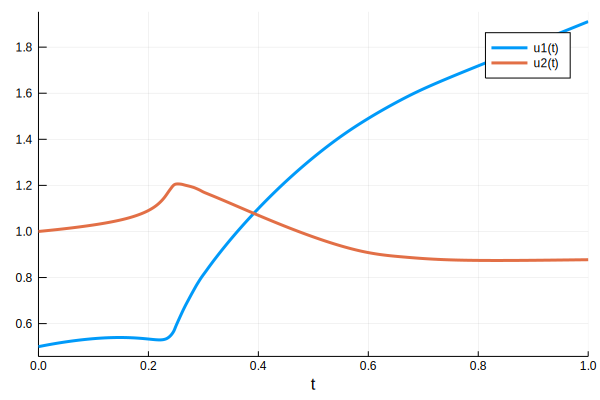

In [86]:
plot(sol,grid=true)
# savefig("vortex_pair_rotating_goza_coordinates.pdf")

### Plot results

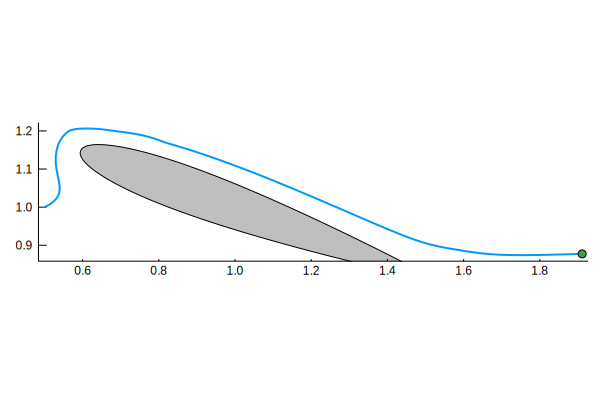

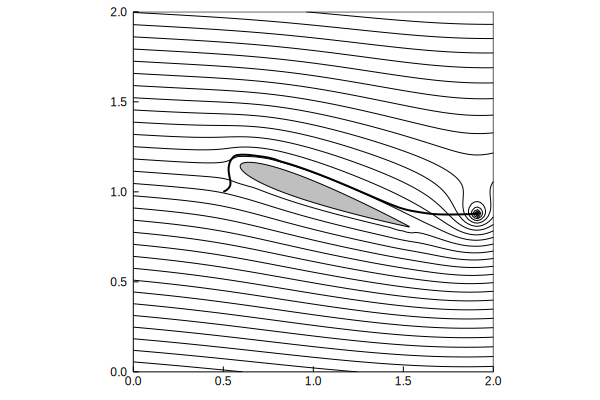

In [92]:
xg,yg = coordinates(s,dx=dx)
coord = [(x,y) for x in xg, y in yg]

p1 = plot(sol,vars=(1,2),lw=2)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
scatter!([sol[end][1]],[sol[end][2]])
xlims!(minimum(sol[1,:])-1*dx,maximum(sol[1,:])+1*dx)
ylims!(minimum(sol[2,:])-1*dx,maximum(sol[2,:])+1*dx)

p4 = plot(sol,vars=(1,2),lw=2,color=:black,legend=false)
plot!(xg,yg,stot,linecolor=:black,levels=31)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)
plot!(xlims=(0,Lx),ylims=(0,Lx));
# savefig("vortex_pair_rotating_goza.pdf")

display(p1)

display(p4)

In [16]:
function addoneto(number::Real)
    return number + 1
end

addoneto (generic function with 2 methods)

In [21]:
number = 2
addoneto(number)
number

2